# Dictionary Learning

In [1]:
import cv2 as cv
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.decomposition import DictionaryLearning
from sklearn.decomposition import MiniBatchDictionaryLearning
from skimage.util import view_as_windows
from skimage.metrics import structural_similarity as ssim

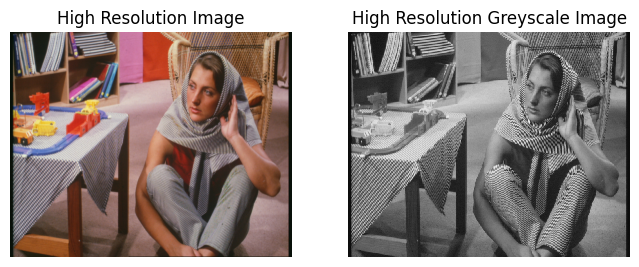

Shape of Image: (576, 720)


In [2]:
#Load an sample Image 
img_loc = "/Users/ltc/Documents/Python Scripts/MTP/Set14/original/barbara.png"
high_res_img = mpimg.imread(img_loc)


#convert from uint8 representation with values between 0 and 255 to 
#a floating point representation with values between 0 and 1
high_res_grey_img = cv.cvtColor(high_res_img, cv.COLOR_RGB2GRAY)

#Display the image
plt.figure(figsize=(8,10))

plt.subplot(1,2,1)
plt.imshow(high_res_img)
plt.axis("off")
plt.title("High Resolution Image", size=12)

plt.subplot(1,2,2)
plt.imshow(high_res_grey_img, vmin=0, vmax=1, cmap="gray", interpolation="nearest")
plt.axis("off")
plt.title("High Resolution Greyscale Image", size=12)
plt.show()

print(f"Shape of Image: {high_res_img.shape[:2]}")

## Extracting Patches

In [3]:
%%time
from sklearn.feature_extraction.image import extract_patches_2d

# Extract reference patches from the whole image
print("Extracting reference patches...\n")
patch_size = (5,5)

data = extract_patches_2d(high_res_grey_img, patch_size)
print(f"Shape of Data: {data.shape}\n")

data = data.reshape(data.shape[0], -1)
print(f"Shape of Data after flattening: {data.shape}\n")

#Standardize the data
data -= np.mean(data, axis=0)

data /= np.std(data, axis=0)
print(f"{data.shape[0]} patches extracted\n")

Extracting reference patches...

Shape of Data: (409552, 5, 5)

Shape of Data after flattening: (409552, 25)

409552 patches extracted

CPU times: user 113 ms, sys: 45.9 ms, total: 159 ms
Wall time: 188 ms


## Learn the dictionary from reference patches

In [4]:
%%capture cap --no-stderr
from time import time

alpha = 0.75

t0 = time()
batch_dl = MiniBatchDictionaryLearning(
    n_components=320,
    batch_size=500,
    alpha=alpha, #sparsity constraint
    max_iter=3, #times the algorithm will loop over all the mini batches before stopping
    shuffle=True,
    verbose=1
)

D = batch_dl.fit(data).components_
dt = time() - t0

print(f"{batch_dl.n_iter_} iterations / {batch_dl.n_steps_} steps in {dt:.2f}.")

/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=9.665e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


In [5]:
#saving the logs to .txt file
with open("Patches.txt", "w") as f:
    f.write(cap.stdout)

In [6]:
#Parsing .txt file 
with open("Patches.txt", "r") as f:
    lines = f.readlines()

with open("Patches.csv", "w") as f_:

    header = ["Minibatch step", "mean batch cost", "ewa cost"]
    writer = csv.DictWriter(f_, fieldnames=header)
    writer.writeheader()
    
    for line in lines[1:]:
        
        if line.startswith("Minibatch"):
            line = line.lower()
            tokens = line.split(": ")
            step_info = tokens[0].split(" ")
            current_step, total_step = step_info[2].split("/")
            try:
                mean = float(tokens[2])
                mean = f"{mean:.2f}"
            except ValueError:
                mean = float(tokens[2].split(",")[0])
                mean = f"{mean:.2f}"
            ewa_mean = None
            if len(tokens) > 3:
                ewa_mean = float(tokens[3].strip())
                ewa_mean = f"{ewa_mean:.2f}"
            writer.writerow({"Minibatch step": current_step, "mean batch cost": mean, "ewa cost":ewa_mean})
    print(f"Successfully Stored as CSV\n")


Successfully Stored as CSV



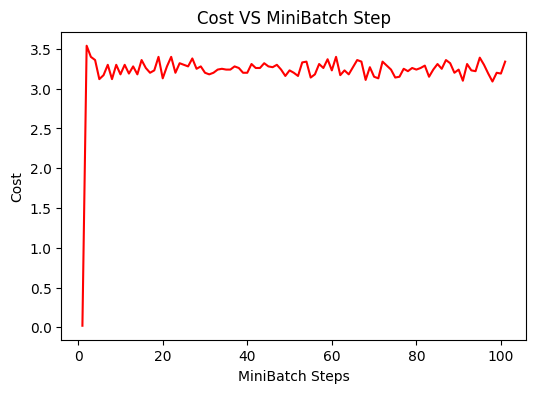

In [7]:
step = []
mean = []
ewa_mean = []
with open("Patches.csv", "r") as f:
    reader = csv.DictReader(f)
    
    for line in reader:
        step.append(float(line["Minibatch step"]))
        mean.append(float(line["mean batch cost"]))
        try: 
            ewa_mean.append(float(line["ewa cost"]))
        except ValueError:
            ewa_mean.append(0)

plt.figure(figsize=(6,4))
plt.plot(step, mean, "r", label="Mean batch cost")
# plt.plot(step, ewa_mean, "b", label="EWA cost")
plt.xlabel("MiniBatch Steps")
plt.ylabel("Cost")
plt.title("Cost VS MiniBatch Step")
plt.show()

## Reconstruction

In [8]:
print(D.shape)

(320, 25)


In [9]:
%%time
"""
Adds the mean (intercept) of the extracted patches to each patch, 
This is done to re-center the patches around their original intensity values 
before the patches were extracted.
"""
intercept = np.mean(data, axis=0)


# batch_dl.set_params(transform_algorithm="omp", transform_n_nonzero_coefs=10)
batch_dl.set_params(transform_algorithm="lars", transform_n_nonzero_coefs=6)

code = batch_dl.transform(data)
patches = np.dot(code, D)

patches += intercept
patches = patches.reshape(data.shape[0], patch_size[0], patch_size[1])

CPU times: user 7min 7s, sys: 3.9 s, total: 7min 10s
Wall time: 7min 12s


In [10]:
print(patches.shape)

(409552, 5, 5)


In [11]:
from sklearn.feature_extraction.image import reconstruct_from_patches_2d

height, width = high_res_grey_img.shape[:2]

reconstructed_img = reconstruct_from_patches_2d(
        patches, (height, width)
)
# Rescale the pixel values to between 0 and 255
reconstructed_img = (reconstructed_img - reconstructed_img.min()) / (reconstructed_img.max() - reconstructed_img.min()) * 255

# Convert the pixel values to integers
reconstructed_img = reconstructed_img.astype(np.uint8)

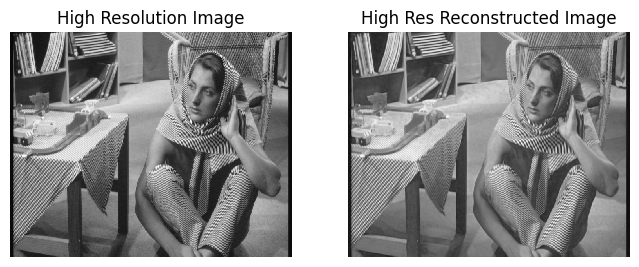

In [17]:
plt.figure(figsize=(8,10))

plt.subplot(1,2,1)
plt.imshow(high_res_grey_img, cmap="gray", interpolation="nearest")
plt.axis("off")
plt.title("High Resolution Image")

plt.subplot(1,2,2)
plt.imshow(reconstructed_img, cmap="gray", interpolation="nearest")
plt.axis("off")
plt.title("High Res Reconstructed Image")
plt.show()


In [13]:
cv.imwrite("Reconstructed_High.png", reconstructed_img)

True

## SSIM

In [14]:
#Change the dtype of images
low_res_grey_img = (high_res_grey_img*255).astype(np.uint8)

# reconstructed_img = (reconstructed_img*255).astype(np.uint8)

# Calculate the SSIM between the reconstructed and original images
ssim_score = ssim(low_res_grey_img, reconstructed_img)

# Print the SSIM score
print(f"SSIM score between Reconstructed and Original: {ssim_score:.2f}")

SSIM score between Reconstructed and Original: 0.92


## Reconstruction Error

In [16]:
# X = np.random.randn(n_samples, n_features)

# # Split the data matrix into training and test sets
# X_train = X[:800] # use the first 800 samples for training
# X_test = X[800:] # use the last 200 samples for testing

# # Define the sparsity parameter alpha
# alpha = 1

# # Create an instance of MiniBatchDictionaryLearning with some parameters
# model = MiniBatchDictionaryLearning(n_components=10, alpha=alpha, max_iter=100, batch_size=50)

# # Fit the model to the training set
# model.fit(X_train)

# # Transform the training and test sets using the learned dictionary
# U_train = model.transform(X_train)
# U_test = model.transform(X_test)

# # Reconstruct the training and test sets using the learned code matrices
# X_train_reconstructed = U_train.dot(model.components_)
# X_test_reconstructed = U_test.dot(model.components_)

# # Compute the reconstruction error for the training and test sets using mean squared error metric
# train_error = mean_squared_error(X_train, X_train_reconstructed)
# test_error = mean_squared_error(X_test, X_test_reconstructed)

# # Print the reconstruction errors
# print("Train error:", train_error)
# print("Test error:", test_error)

In [ ]:
#DUMP
# intercept = np.mean(data, axis=0)

# transform_algorithms = [
#     ("Orthogonal Matching Pursuit\n1 atom", "omp", {"transform_n_nonzero_coefs": 1}),
#     ("Orthogonal Matching Pursuit\n2 atoms", "omp", {"transform_n_nonzero_coefs": 2}),
#     ("Least-angle regression\n4 atoms", "lars", {"transform_n_nonzero_coefs": 4}),
#     ("Thresholding\n alpha=0.1", "threshold", {"transform_alpha": 0.1}),
# ]

# reconstructions = {}
# for title, transform_algorithm, kwargs in transform_algorithms:
#     print(title + "...")
#     reconstructions[title] = low_res_grey_img.copy()
#     t0 = time()
#     batch_dl.set_params(transform_algorithm=transform_algorithm, **kwargs)
#     code = batch_dl.transform(data)
#     patches = np.dot(code, D)

#     patches += intercept
#     patches = patches.reshape(len(data), *patch_size)
#     if transform_algorithm == "threshold":
#         patches -= patches.min()
#         patches /= patches.max()
#     reconstructions[title] = reconstruct_from_patches_2d(
#         patches, (height, width)
#     )
#     dt = time() - t0
#     print("done in %.2fs." % dt)

In [ ]:
# def print_loss(model, X):
#     # Get dictionary and code from model
#     D = model.components_
#     U = model.transform(X)
#     # Reconstruct data using dictionary and code
#     X_reconstructed = np.dot(U, D)
#     # Calculate mean squared error between original and reconstructed data
#     mse = mean_squared_error(X, X_reconstructed)
#     # Print loss value
#     print(f"Loss: {mse}")